In [2]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numba import njit, prange
import itertools
import math
import haversine as hs

In [3]:
df = pd.read_csv("sample_dataset.csv")

In [4]:
# the best model is the one that the weights of the clusters are the most similar and the locations are the most close to each other
def cluster_data(data, min_cluster_size, max_cluster_size, cluster_method):
    cluster_sizes = range(min_cluster_size, max_cluster_size)
    models = []
    for size in cluster_sizes:
        if cluster_method == 'kmeans':
            model = KMeans(n_clusters=size, random_state=0).fit(data)
        elif cluster_method == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=size, affinity='euclidean', linkage='ward').fit(data)
        models.append(model)
    return models


def calculate_cluster_weight(model, data):
    cluster_count = len(set(model.labels_))
    cluster_weights = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_weight = cluster['Weight'].mean()
        cluster_weights.append(cluster_weight)
    return cluster_weights


def calculate_cluster_distance(model, data):
    cluster_count = len(set(model.labels_))
    cluster_distances = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_distance = cluster['Latitude'].max() - cluster['Latitude'].min() + cluster['Longitude'].max() - cluster[
            'Longitude'].min()
        cluster_distances.append(cluster_distance)
    return cluster_distances


def calculate_cluster_score(model, data):
    cluster_weights = calculate_cluster_weight(model, data)
    cluster_distances = calculate_cluster_distance(model, data)
    score = 0
    for i in range(len(cluster_weights)):
        for j in range(i + 1, len(cluster_weights)):
            score += abs(cluster_weights[i] - cluster_weights[j]) / abs(
                cluster_distances[i] - cluster_distances[j]) * 10
    return score


def calculate_best_model(models, data):
    scores = []
    for model in models:
        score = calculate_cluster_score(model, data)
        scores.append(score)
    best_model_index = scores.index(max(scores))
    return models[best_model_index]

models = cluster_data(df.iloc[:, 1:4], 2, 50, 'agglomerative')
best_model = calculate_best_model(models, df.iloc[:, 1:4])

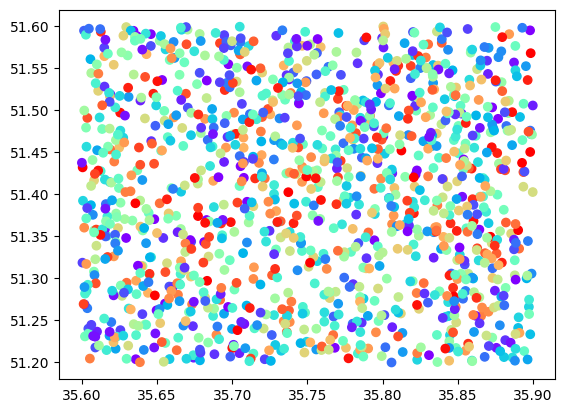

In [5]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=best_model.labels_, cmap="rainbow")

<BarContainer object of 49 artists>

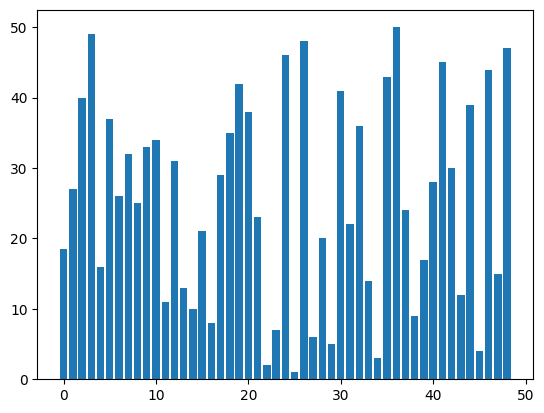

In [6]:
#bar plot of the weights of each cluster
cluster_weights = calculate_cluster_weight(best_model, df.iloc[:, 1:4])
plt.bar(range(len(cluster_weights)), cluster_weights)

In [7]:
def normal_dist(x, mean, sd):
    prob_density = (np.pi * sd) * np.exp(-0.5 * ((x - mean) / sd) ** 2)
    return prob_density


df['std_weight'] = df['Weight'].apply(lambda x: normal_dist(x, df['Weight'].mean(), df['Weight'].std()))
df

,Location ID,Latitude,Longitude,Weight,std_weight
0,1,35.857621,51.536474,8,21.580582
1,51,35.881941,51.366560,30,43.109375
2,101,35.603620,51.264557,25,45.213557
3,151,35.796481,51.437253,49,11.981049
4,201,35.780196,51.465165,14,32.849692
...,...,...,...,...,...
1245,1050,35.835749,51.357068,45,18.129390
1246,1100,35.820666,51.420291,47,14.880824
1247,1150,35.660637,51.406566,25,45.213557
1248,1200,35.664960,51.542360,46,16.464634


In [8]:
# number of locations in each cluster
def calculate_cluster_size(model, data):
    cluster_count = len(set(model.labels_))
    cluster_sizes = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_size = cluster.shape[0]
        cluster_sizes.append(cluster_size)
    return cluster_sizes


calculate_cluster_size(best_model, df.iloc[:, 1:4])

[38,
 30,
 27,
 36,
 27,
 27,
 27,
 25,
 25,
 23,
 29,
 28,
 24,
 24,
 24,
 30,
 28,
 28,
 27,
 31,
 21,
 33,
 28,
 25,
 32,
 28,
 21,
 28,
 27,
 23,
 29,
 24,
 26,
 19,
 24,
 22,
 20,
 26,
 27,
 23,
 22,
 20,
 23,
 22,
 23,
 20,
 20,
 19,
 17]

<BarContainer object of 49 artists>

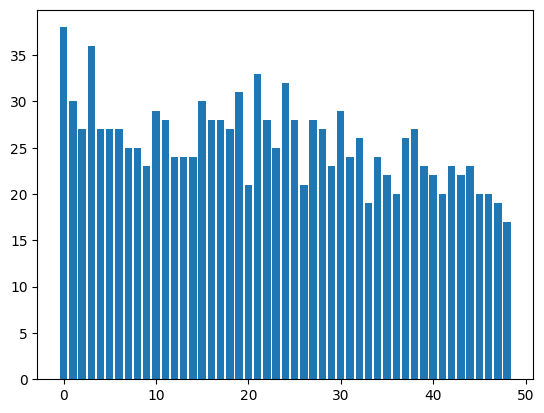

In [9]:
#bar plot of the number of locations in each cluster
cluster_sizes = calculate_cluster_size(best_model, df.iloc[:, 1:4])

plt.bar(range(len(cluster_sizes)), cluster_sizes)


## calculate shortest path between all locations in a cluster based on their coordinates
### (traveling salesman problem)


In [10]:
def distance_between_points(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    radius = 6371  # km

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    sin_dlat = np.sin(dlat / 2)
    sin_dlon = np.sin(dlon / 2)
    cos_lat1 = np.cos(np.radians(lat1))
    cos_lat2 = np.cos(np.radians(lat2))

    a = sin_dlat * sin_dlat + cos_lat1 * cos_lat2 * sin_dlon * sin_dlon
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d


In [146]:
def calculate_shortest_path(locations):
    shortest_distance = math.inf
    shortest_path = None
    for path in itertools.permutations(locations):
        distance = 0
        for i in range(len(path) - 1):
            distance += distance_between_points(path[i], path[i + 1])
            if distance > shortest_distance:
                break  # Exit early if the distance exceeds the current shortest distance
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = path
    return shortest_path, shortest_distance


In [99]:
# calculate_shortest_path([(35.6, 51.2), (35.7, 51.3), (35.8, 51.4), (35.9, 51.5)])
calculate_shortest_path([[35.655492, 51.223262],
                         [35.683981, 51.223777],
                         [35.642096, 51.245276],
                         [35.652076, 51.246849],
                         [35.602044, 51.231012],
                         [35.604192, 51.234337],
                         [35.634498, 51.245595]
                         ])

(([35.683981, 51.223777],
  [35.655492, 51.223262],
  [35.652076, 51.246849],
  [35.642096, 51.245276],
  [35.634498, 51.245595],
  [35.604192, 51.234337],
  [35.602044, 51.231012]),
 11.201146890610607)

In [147]:
#print all the locations in each cluster
def print_cluster_locations(model, data):
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        print(cluster)


def return_locations_in_target_cluster(model, data, target_cluster):
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        if i == target_cluster:
            return cluster

In [148]:
def return_locations_list_in_target_cluster(model, data, target_cluster):
    # return [[lat, lon], [lat, lon], ...]
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        if i == target_cluster:
            return cluster[['Latitude', 'Longitude']].values.tolist()

In [149]:
import math
import numpy as np


def haversine_distance(coord1, coord2):
    """
    Calculate the Haversine distance (in meters) between two sets of latitude and longitude coordinates.
    """
    # Earth radius in meters
    earth_radius = 6371000

    # Convert latitude and longitude to radians
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1_rad = lat1 * (3.141592653589793 / 180)
    lon1_rad = lon1 * (3.141592653589793 / 180)
    lat2_rad = lat2 * (3.141592653589793 / 180)
    lon2_rad = lon2 * (3.141592653589793 / 180)

    # Haversine formula
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad
    a = (pow(math.sin(d_lat / 2), 2) +
         math.cos(lat1_rad) * math.cos(lat2_rad) * pow(math.sin(d_lon / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance


def nearest_neighbor_algorithm(start, locations):
    """
    Calculate the optimized path from the start point to the end point using latitude and longitude coordinates.

    Parameters:
    start (tuple): Latitude and longitude of the start point.
    locations (list): List of latitude and longitude coordinates for all points.

    Returns:
    list: The optimized path as a list of latitude and longitude coordinates.
    """
    # Create a copy of the list of locations to keep track of visited nodes
    unvisited = list(locations)
    path = [start]

    # Find the nearest neighbor for each point and add it to the path
    while unvisited:
        current = path[-1]
        nearest_dist = float('inf')
        nearest_neighbor = None

        for neighbor in unvisited:
            dist = haversine_distance(current, neighbor)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_neighbor = neighbor

        path.append(nearest_neighbor)
        unvisited.remove(nearest_neighbor)

    return path



In [150]:
locations_list_in_cluster_42 = return_locations_list_in_target_cluster(best_model, df.iloc[:, 1:4], 42)
optimized_path = nearest_neighbor_algorithm(locations_list_in_cluster_42[0], locations_list_in_cluster_42)
optimized_path

[[35.655492, 51.223262],
 [35.655492, 51.223262],
 [35.652076, 51.246849],
 [35.650867, 51.257559],
 [35.642096, 51.245276],
 [35.634498, 51.245595],
 [35.611353, 51.22022],
 [35.602044, 51.231012],
 [35.604192, 51.234337],
 [35.629727, 51.204423],
 [35.683981, 51.223777]]

In [151]:
lats, lons = zip(*optimized_path)

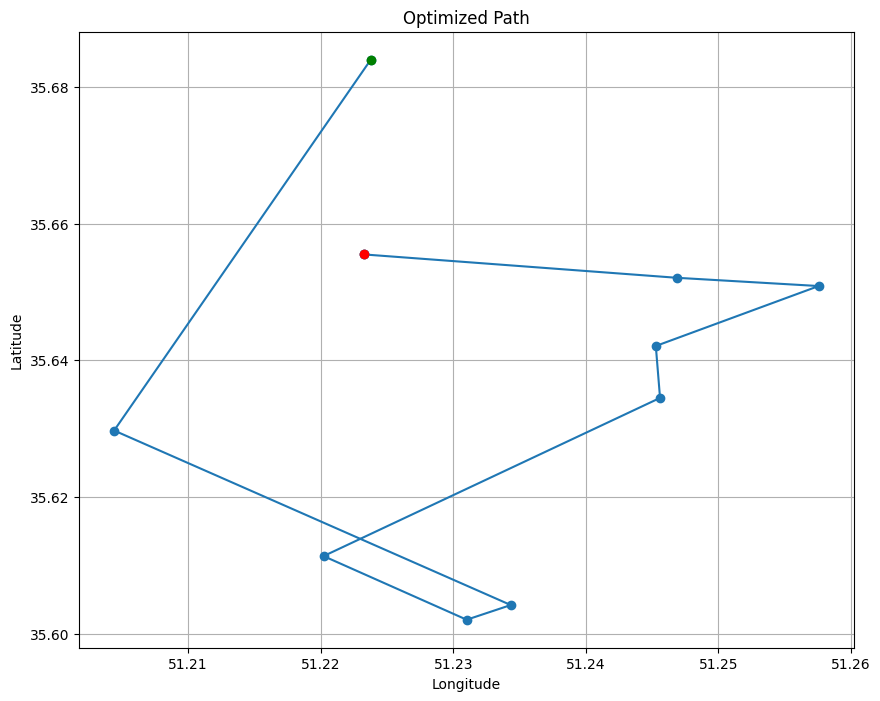

In [152]:
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, marker='o', linestyle='-')
plt.plot(lons[0], lats[0], marker='o', color='red')  # Starting point
plt.plot(lons[-1], lats[-1], marker='o', color='green')  # Ending point
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Path")
plt.grid()
plt.show()

In [9]:
import itertools
import math


def haversine_distance(coord1, coord2):
    """
    Calculate the Haversine distance (in meters) between two sets of latitude and longitude coordinates.
    """
    # Earth radius in meters
    earth_radius = 6371000

    # Convert latitude and longitude to radians
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1_rad = lat1 * (3.141592653589793 / 180)
    lon1_rad = lon1 * (3.141592653589793 / 180)
    lat2_rad = lat2 * (3.141592653589793 / 180)
    lon2_rad = lon2 * (3.141592653589793 / 180)

    # Haversine formula
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad
    a = (pow(math.sin(d_lat / 2), 2) +
         math.cos(lat1_rad) * math.cos(lat2_rad) * pow(math.sin(d_lon / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance


def held_karp_algorithm(start, locations):
    """
    Calculate the most optimized path from the start point to the end point using latitude and longitude coordinates.

    Parameters:
    start (tuple): Latitude and longitude of the start point.
    locations (list): List of latitude and longitude coordinates for all points.

    Returns:
    list: The optimized path as a list of latitude and longitude coordinates.
    """
    num_points = len(locations)
    all_points = [start] + locations

    # Initialize the memoization table for dynamic programming
    memo = {}

    # Helper function for memoization
    def dp_mask(mask, pos):
        if mask == (1 << num_points) - 1:
            return haversine_distance(all_points[pos], start)

        if (mask, pos) in memo:
            return memo[(mask, pos)]

        min_distance = float('inf')

        for next_pos in range(1, num_points + 1):
            if not (mask & (1 << next_pos)):
                new_mask = mask | (1 << next_pos)
                distance = haversine_distance(all_points[pos], all_points[next_pos]) + dp_mask(new_mask, next_pos)
                min_distance = min(min_distance, distance)

        memo[(mask, pos)] = min_distance
        return min_distance

    # Calculate the optimal distance
    optimal_distance = dp_mask(1, 0)

    # Reconstruct the path based on the memoization table
    path = [start]
    mask = 1

    for i in range(1, num_points + 1):
        for next_pos in range(1, num_points + 1):
            if not (mask & (1 << next_pos)):
                if dp_mask(mask, 0) == haversine_distance(all_points[0], all_points[next_pos]) + dp_mask(
                        mask | (1 << next_pos), next_pos):
                    path.append(all_points[next_pos])
                    mask |= (1 << next_pos)
                    break

    return path, optimal_distance


# Example usage:
data = [
    [35.683981, 51.223777],
    [35.642096, 51.245276],
    [35.652076, 51.246849],
    [35.602044, 51.231012],
    [35.604192, 51.234337],
    [35.634498, 51.245595]
]

start_point = (35.683981, 51.223777)  # Latitude and longitude of the starting point

optimized_path, optimal_distance = held_karp_algorithm(start_point, data)
print("Optimized path:", optimized_path)
print("Optimal distance:", optimal_distance)


Optimized path: [(35.683981, 51.223777), [35.683981, 51.223777], [35.652076, 51.246849], [35.642096, 51.245276], [35.602044, 51.231012], [35.604192, 51.234337]]
Optimal distance: 19080.903311076603


In [10]:

optimized_path, optimal_distance = held_karp_algorithm(locations_list_in_cluster_42[0], locations_list_in_cluster_42)
print("Optimized path:", optimized_path)
print("Optimal distance:", optimal_distance)

NameError: name 'locations_list_in_cluster_42' is not defined

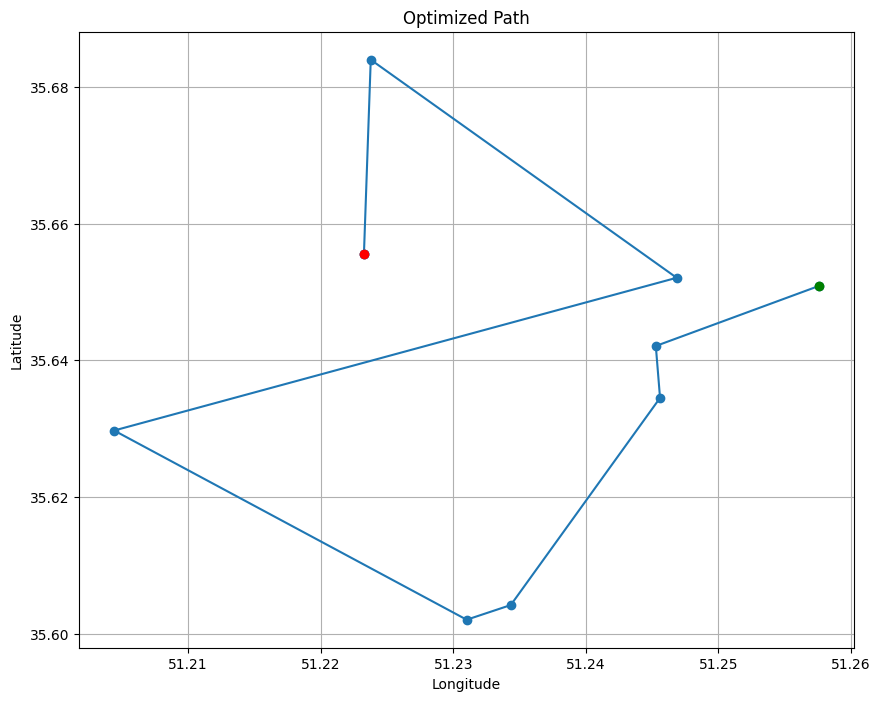

In [155]:
lats, lons = zip(*optimized_path)
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, marker='o', linestyle='-')
plt.plot(lons[0], lats[0], marker='o', color='red')  # Starting point
plt.plot(lons[-1], lats[-1], marker='o', color='green')  # Ending point
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Path")
plt.grid()
plt.show()

Evaluate model by real data

In [11]:
df_real_data = pd.read_excel('CargoSample.xlsx')
df_real_data = df_real_data.loc[df_real_data['CargoDate'] == '2023-07-02']
df_real_data = df_real_data.dropna()
df_real_data = df_real_data[df_real_data['LatitudePoint'] > 0]
df_real_data.head()

,Cargo_ID,DepartmentInfo_ID,CargoDate,SaleInvoice_ID,MainAccount_ID,LatitudePoint,LongitudePoint
9,140218453,18,2023-07-02,1402189192,330631,38.075466,46.343969
23,140218453,18,2023-07-02,1402189218,330645,38.072503,46.301797
53,140218448,18,2023-07-02,1402189055,330696,38.051090,46.317389
54,140218448,18,2023-07-02,1402189151,330696,38.051090,46.317389
56,140218452,18,2023-07-02,1402189472,330696,38.051090,46.317389


In [12]:
df2 = pd.read_excel('CargoSample.xlsx')
df2 = df2.loc[df2['CargoDate'] == '2023-07-02']
df2 = df2.dropna()
df2 = df2.sort_values('Cargo_ID')
a = -1
b = 0
df2 = df2[df2['LatitudePoint'] > 0]
for ind, val in enumerate(df2['Cargo_ID'].to_list()):
    if val != a:
        a = val
        b += 1
        df2 = df2.replace([val], b)
df2.head()

,Cargo_ID,DepartmentInfo_ID,CargoDate,SaleInvoice_ID,MainAccount_ID,LatitudePoint,LongitudePoint
9762,1,8,2023-07-02,1402088558,347926,32.677001,51.529933
18593,1,8,2023-07-02,1402088649,371004,32.660301,51.552088
10383,1,8,2023-07-02,1402088411,140100287,32.680437,51.549944
16510,1,8,2023-07-02,1402088544,348242,32.693774,51.534673
18266,1,8,2023-07-02,1402088667,369714,32.632840,51.370313


In [13]:
lat1 = df2.iloc[1].LatitudePoint
long1 = df2.iloc[1].LongitudePoint
lat2 = df2.iloc[2].LatitudePoint
long2 = df2.iloc[2].LongitudePoint
lat3 = df2.iloc[3].LatitudePoint
long3 = df2.iloc[3].LongitudePoint

In [18]:
import requests
import json


r = requests.get(f"http://router.project-osrm.org/route/v1/car/{long1},{lat1};{long2},{lat2};{long3},{lat3}?overview=false")


routes = json.loads(r.content)
route_1 = routes.get("routes")[0]

In [19]:
route_1

{'legs': [{'steps': [],
   'summary': '',
   'weight': 243.2,
   'duration': 243.2,
   'distance': 3124.8},
  {'steps': [],
   'summary': '',
   'weight': 243.3,
   'duration': 243.3,
   'distance': 2729.8}],
 'weight_name': 'routability',
 'weight': 486.5,
 'duration': 486.5,
 'distance': 5854.6}

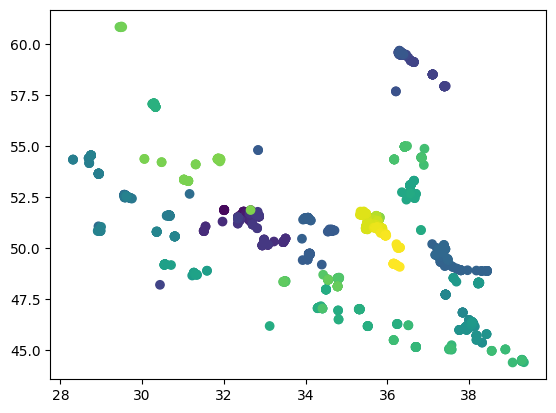

In [20]:
plt.scatter(df2.iloc[:, 5], df2.iloc[:, 6], c=df2.iloc[:, 0])

<BarContainer object of 100 artists>

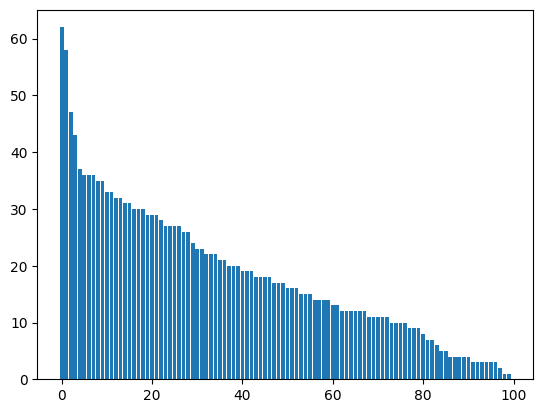

In [21]:
#bar plot number of rows in each cluster df2.iloc[:, 0]
plt.bar(range(len(df2.iloc[:, 0].unique())), df2.iloc[:, 0].value_counts())

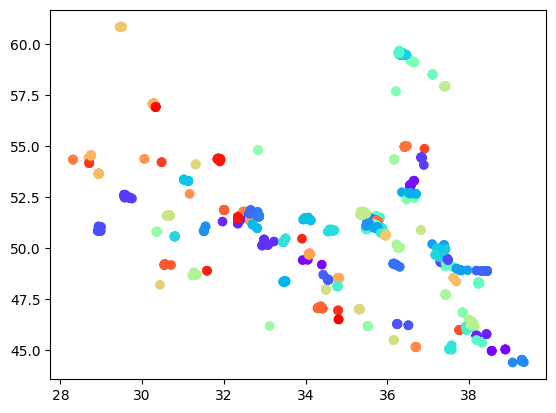

In [22]:
test_model = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
test_model.fit(df2[['LatitudePoint', 'LongitudePoint']])
plt.scatter(df2.iloc[:, 5], df2.iloc[:, 6], c=test_model.labels_, cmap="rainbow")

<BarContainer object of 1849 artists>

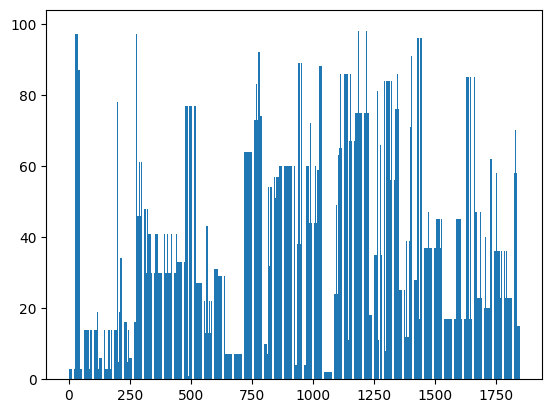

In [23]:
plt.bar(range(len(test_model.labels_)), test_model.labels_)

In [24]:
complete_df = pd.read_excel('CargoSample.xlsx')
dates = complete_df['CargoDate'].unique()
dates

array(['2023-07-03T00:00:00.000000000', '2023-07-11T00:00:00.000000000',
       '2023-07-04T00:00:00.000000000', '2023-07-10T00:00:00.000000000',
       '2023-07-08T00:00:00.000000000', '2023-07-02T00:00:00.000000000',
       '2023-07-06T00:00:00.000000000', '2023-07-12T00:00:00.000000000',
       '2023-07-13T00:00:00.000000000', '2023-07-05T00:00:00.000000000',
       '2023-07-15T00:00:00.000000000', '2023-07-09T00:00:00.000000000',
       '2023-07-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [43]:
#length of each date data 
for date in dates:
    print(len(complete_df[complete_df['CargoDate'] == date]))

1424
1583
2271
1333
1775
1850
1918
1576
1647
1611
970
1857
36


In [25]:
def compare_machine_to_human_clustering():
    number_of_dates = len(dates)
    sum_of_scores = 0
    average = 0
    for date in dates:
        t_df = complete_df.loc[complete_df['CargoDate'] == date]
        number_of_visitors = t_df.iloc[:, 0].unique().shape[0]
        t_df = t_df.dropna()
        t_df = t_df[t_df['LatitudePoint'] > 0]
        test_model = AgglomerativeClustering(n_clusters=number_of_visitors, affinity='euclidean', linkage='ward')
        test_model.fit(t_df[['LatitudePoint', 'LongitudePoint']])
        t_df['cluster'] = test_model.labels_
        best_point = 0
        current_point = 0
        for cluster in t_df['cluster'].unique():
            t_df2 = t_df.loc[t_df['cluster'] == cluster]
            for cargo_id in t_df2['Cargo_ID'].unique():
                best_point += 1
                t_df3 = t_df2.loc[t_df2['Cargo_ID'] == cargo_id]
                current_point += t_df3.shape[0] / t_df2.shape[0]
        sum_of_scores += (current_point/best_point) * 100
    
    average = sum_of_scores / number_of_dates
    return average


In [26]:
compare_machine_to_human_clustering()

53.1612729435728

In [51]:
test1 = complete_df[complete_df['Cargo_ID'] == 140218461]
test1

,Cargo_ID,DepartmentInfo_ID,CargoDate,SaleInvoice_ID,MainAccount_ID,LatitudePoint,LongitudePoint
0,140218461,18,2023-07-03,1402189460,330623,38.475766,47.063073
1,140218504,18,2023-07-11,14021810299,330623,38.475766,47.063073
2,140218504,18,2023-07-11,14021810493,330623,38.475766,47.063073
3,140218465,18,2023-07-04,1402189463,330627,38.061419,46.322348
4,140218492,18,2023-07-10,14021810212,330627,38.061419,46.322348


In [64]:
import requests
import json



In [ ]:
def build_df_with_cluster(df):
    t_df = df.loc[df['CargoDate'] == date]
    number_of_visitors = t_df.iloc[:, 0].unique().shape[0]
    t_df = t_df.dropna()
    t_df = t_df[t_df['LatitudePoint'] > 0]
    test_model = AgglomerativeClustering(n_clusters=number_of_visitors, affinity='euclidean', linkage='ward')
    test_model.fit(t_df[['LatitudePoint', 'LongitudePoint']])
    t_df['cluster'] = test_model.labels_
    return t_df

In [65]:
for date in dates:
    t_df = build_df_with_cluster(complete_df)
    best_point = 0
    current_point = 0
    for cluster in t_df['cluster'].unique():
        t_df2 = t_df.loc[t_df['cluster'] == cluster]
        for cargo_id in t_df2['Cargo_ID'].unique():
            best_point += 1
            t_df3 = t_df2.loc[t_df2['Cargo_ID'] == cargo_id]
            current_point += t_df3.shape[0] / t_df2.shape[0]
    #calculate maximum distance between two points in each cluster with latitude and longitude
    machine_computed_distance = 0
    for cluster in t_df['cluster'].unique():
        t_df2 = t_df.loc[t_df['cluster'] == cluster]
        distance = calculate_distance_batch(t_df2[['LatitudePoint', 'LongitudePoint']].values.tolist())
        machine_computed_distance += distance
                
    human_computed_distance = 0
    for user_cluster in t_df['Cargo_ID'].unique():
        t_df2 = t_df.loc[t_df['Cargo_ID'] == user_cluster]
        distance = calculate_distance_batch(t_df2[['LatitudePoint', 'LongitudePoint']].values.tolist())
        human_computed_distance += distance

    print("***************************************************")
    print("AI MAXIMUM DISTANCE RESULT", machine_computed_distance, "HUMAN MAXIMUM DISTANCE RESULT", human_computed_distance)
    print("AI ACCURACY COMPARED TO HUMAN", (current_point/best_point) * 100, number_of_visitors)
    print("***************************************************")

http://router.project-osrm.org/route/v1/car/47.063073,38.475766;47.116485,38.246681;47.116485,38.246681;47.132431,38.07909;47.066255,38.473173;47.064187,38.474763;47.067725,38.475019;47.068176,38.475697;47.06476,38.474403;47.06476,38.474403;47.06879,38.477298?overview=false
Total Distance: 172796.5
http://router.project-osrm.org/route/v1/car/46.325898,38.078116;46.325898,38.078116;46.286583,38.068388;46.286583,38.068388;46.317389,38.05109;46.360109,38.062531;46.360109,38.062531;46.317125,38.051421;46.317125,38.051421;46.286683,38.093503;46.286683,38.093503;46.292393,38.068381;46.292393,38.068381;46.25408,38.069955;46.257578,38.060955;46.3370803,38.0759861;46.22131,38.090639;46.22131,38.090639;46.22131,38.090639;46.297145,38.06698;46.29954,38.088757;46.276221,38.099052;46.27031,38.062997;46.275043,38.069966;46.31531,38.05159;46.278546,38.083461;46.324246,38.057644;46.340701,38.046275;46.316292,38.058924;46.24833,38.066859;46.24833,38.066859;46.288571,38.068387;46.320924,38.060274;46.320

JSONDecodeError: Expecting value: line 1 column 1 (char 0)